In [1]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

In [2]:
#function
#TODO AGGIUNGERE PLOT E DIFFERENZE + REFACTORING
def trova_elemento_piu_comune(array_di_coppie):
    # Unisci tutte le coppie in un unico elenco
    tutti_elementi = [elemento for coppia in array_di_coppie for elemento in coppia]

    # Conta le occorrenze di ciascun elemento
    conteggio_elementi = Counter(tutti_elementi)

    # Trova l'elemento più comune
    elemento_piu_comune, conteggio_max = conteggio_elementi.most_common(1)[0]

    return elemento_piu_comune, conteggio_max

def elimina_coppie_con_elemento(array_di_coppie, elemento_da_elim):
    # Utilizza una list comprehension per filtrare le coppie che non contengono l'elemento da eliminare
    nuove_coppie = [coppia for coppia in array_di_coppie if elemento_da_elim not in coppia]

    return nuove_coppie

def elimina_elemento_coppie(indices2,to_remove):
    for pair in indices2:
        to_remove.append(pair[0])
    indices2.clear()

In [3]:
#lettura dataset originale + aggiunta id
df = pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')
df['id'] = range(0, len(df))
df

,text,label,prompt_name,source,RDizzl3_seven,id
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,0
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,1
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,2
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,3
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,4
...,...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,44863
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,44864
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,44865
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True,44866


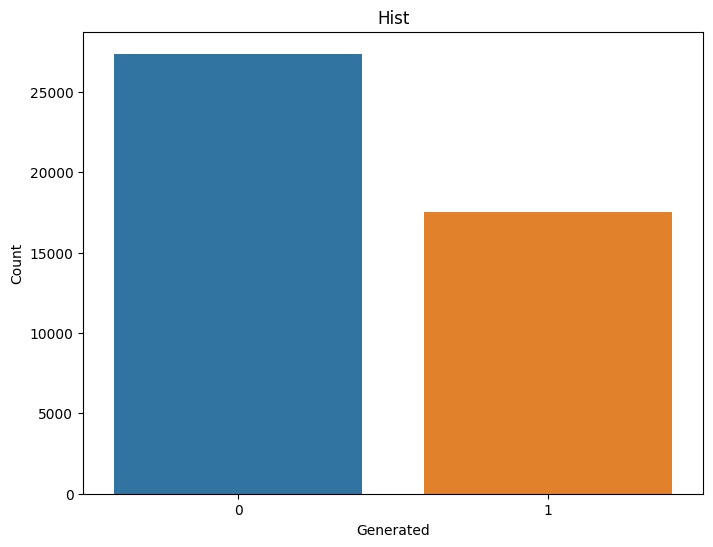

label
0    27371
1    17497
Name: count, dtype: int64


In [4]:
# conteggio label dataset
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Hist')
plt.xlabel('Generated')
plt.ylabel('Count')
plt.show()

print(label_counts)

In [5]:
# per ogni prompt contiamo le label
prompt_count = df.groupby(['prompt_name', 'label']).size().unstack()
prompt_count

prompt_df = pd.DataFrame(columns=['prompt_name', 'human', 'ai'])
grouped_df = df.groupby('prompt_name')['label'].value_counts().unstack().reset_index()

# Assegnare i risultati al nuovo DataFrame
prompt_df['prompt_name'] = grouped_df['prompt_name']
prompt_df['human'] = grouped_df[0]
prompt_df['ai'] = grouped_df[1]

prompt_df

,prompt_name,human,ai
0,"""A Cowboy Who Rode the Waves""",1372,524
1,Car-free cities,2666,2051
2,Cell phones at school,1656,463
3,Community service,1542,550
4,Distance learning,2157,3397
5,Does the electoral college work?,2714,1720
6,Driverless cars,1886,364
7,Exploring Venus,1862,314
8,Facial action coding system,2167,917
9,Grades for extracurricular activities,1626,490


In [6]:
# Similarità tra i testi umani e individuazione id da eliminare

ids_to_remove = []

#qui ci stanno i prompt che contengono similarità tra i testi umani
#prompt_similarity = ['Car-free cities','Does the electoral college work?','Phones and driving']

for prompt in prompt_df['prompt_name'].unique():
    # Filter the dataframe based on label and prompt_name
    filtered_df = df.loc[(df['label'] == 0) & (df['prompt_name'] == prompt), ['text', 'id']]

    # Create a TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the text data
    tfidf_matrix = vectorizer.fit_transform(filtered_df['text'])

    # Calculate cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Create a DataFrame with cosine similarity values
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, columns=filtered_df['id'], index=filtered_df['id'])

    # Set a threshold
    threshold = 0.9

    # Find indices of pairs with similarity greater than the threshold
    indices = [(filtered_df.index[i], filtered_df.index[j]) for i in range(len(cosine_sim_df))
               for j in range(i + 1, len(cosine_sim_df.columns))
               if cosine_sim_df.iloc[i, j] > threshold]
    
    while len(indices)>0:
        da_eliminare, count = trova_elemento_piu_comune(indices)
        if count > 1:
            indices = elimina_coppie_con_elemento(indices,da_eliminare)
            ids_to_remove.append(da_eliminare)
        else:
            elimina_elemento_coppie(indices,ids_to_remove)

In [7]:
# eliminiamo gli id umani con alta similarità
df = df[~df['id'].isin(ids_to_remove)]

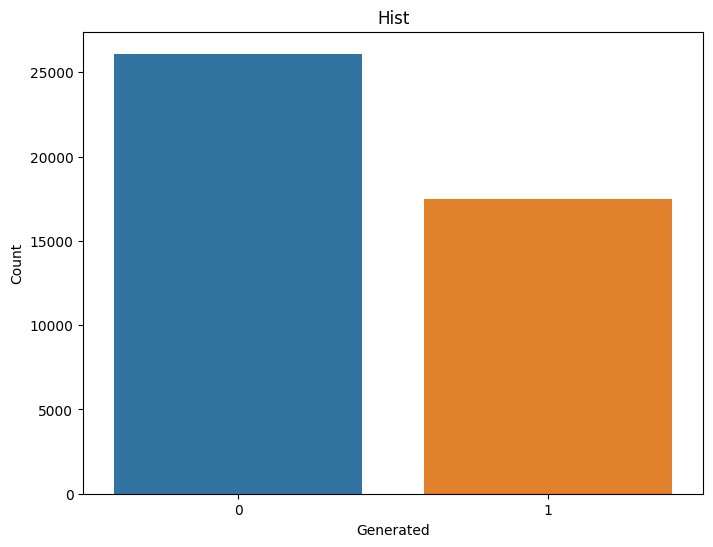

label
0    26105
1    17497
Name: count, dtype: int64


In [8]:
# conteggio label dataset ripulito
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Hist')
plt.xlabel('Generated')
plt.ylabel('Count')
plt.show()

print(label_counts)

In [9]:
# per ogni prompt contiamo le label dal dataset ripulito
prompt_count = df.groupby(['prompt_name', 'label']).size().unstack()
prompt_count

prompt_df = pd.DataFrame(columns=['prompt_name', 'human', 'ai'])
grouped_df = df.groupby('prompt_name')['label'].value_counts().unstack().reset_index()

# Assegnare i risultati al nuovo DataFrame
prompt_df['prompt_name'] = grouped_df['prompt_name']
prompt_df['human'] = grouped_df[0]
prompt_df['ai'] = grouped_df[1]

prompt_df

,prompt_name,human,ai
0,"""A Cowboy Who Rode the Waves""",1372,524
1,Car-free cities,2006,2051
2,Cell phones at school,1656,463
3,Community service,1542,550
4,Distance learning,2157,3397
5,Does the electoral college work?,2125,1720
6,Driverless cars,1886,364
7,Exploring Venus,1862,314
8,Facial action coding system,2167,917
9,Grades for extracurricular activities,1626,490


In [10]:
#TODO Similarità AI

In [22]:
treshold = 500
# prompt che hanno bisogno di generazione di nuovi testi con label 1
to_generate = prompt_df[prompt_df['ai'] + treshold < prompt_df['human']]
to_generate['difference'] = to_generate['human'] - to_generate['ai']
to_generate

/tmp/ipykernel_42/3378537576.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_generate['difference'] = to_generate['human'] - to_generate['ai']


,prompt_name,human,ai,difference
0,"""A Cowboy Who Rode the Waves""",1372,524,848
2,Cell phones at school,1656,463,1193
3,Community service,1542,550,992
6,Driverless cars,1886,364,1522
7,Exploring Venus,1862,314,1548
8,Facial action coding system,2167,917,1250
9,Grades for extracurricular activities,1626,490,1136
11,Phones and driving,1151,415,736
13,Summer projects,1750,951,799
14,The Face on Mars,1583,310,1273


In [12]:
# controlliamo lunghezza testi (ci servirà per la generazione)
df['text_length'] = df['text'].str.len()
text_len_mean = int(df.query("label == 0")['text_length'].mean())
text_len_std = int(df.query("label == 0")['text_length'].std())

print(f"Mean length of train essays by human in our dataset: {text_len_mean}")
print(f"Mean standard deviation of train essays by human in our dataset: {text_len_std}")

df = df.drop('text_length', axis=1)

Mean length of train essays by human in our dataset: 2306
Mean standard deviation of train essays by human in our dataset: 1116


/tmp/ipykernel_42/4036146841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['text'].str.len()
